## Imports

In [11]:
import os
import json
from pyspark.sql import DataFrame, SparkSession, functions as F
from pyspark.conf import SparkConf
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, BooleanType, LongType, DoubleType, ArrayType, DateType
from pyspark import SparkContext
from matplotlib import pyplot as plt
import seaborn as sns

## Create remote Spark session

In [ ]:
# Only execute this cell once.
if '_EXECUTED_' in globals():
    # check if variable '_EXECUTED_' exists in the global variable namespace
    print("Already been executed once, not running again!")
else:
    print("Cell has not been executed before, running...")

    # Two files are automatically read: JobParameters.json for the Spark Cluster job using a temporary spark instance
    # and JobParameters.json for the Jupyter Lab job to extract the hostname of the cluster. 

    MASTER_HOST_NAME = None

    # Open the parameters Jupyter Lab app was launched with
    with open('/work/JobParameters.json', 'r') as file:
        JUPYTER_LAB_JOB_PARAMS = json.load(file)
        # from pprint import pprint; pprint(JUPYTER_LAB_JOB_PARAMS) 
        for resource in JUPYTER_LAB_JOB_PARAMS['request']['resources']:
            if 'hostname' in resource.keys():
                MASTER_HOST_NAME = resource['hostname']

    MASTER_HOST = f"spark://{MASTER_HOST_NAME}:7077"

    conf = SparkConf().setAll([
            ("spark.app.name", 'reading_job_params_app'), 
            ("spark.master", MASTER_HOST),
        ])
    spark = SparkSession.builder.config(conf=conf)\
                                .getOrCreate()

    CLUSTER_PARAMETERS_JSON_DF = spark.read.option("multiline","true").json('/work/JobParameters.json')

    # Extract cluster info from the specific JobParameters.json
    NODES = CLUSTER_PARAMETERS_JSON_DF.select("request.replicas").first()[0]
    CPUS_PER_NODE = CLUSTER_PARAMETERS_JSON_DF.select("machineType.cpu").first()[0] - 1
    MEM_PER_NODE = CLUSTER_PARAMETERS_JSON_DF.select("machineType.memoryInGigs").first()[0]

    CLUSTER_CORES_MAX = CPUS_PER_NODE * NODES
    CLUSTER_MEMORY_MAX = MEM_PER_NODE * NODES 
    
    if CPUS_PER_NODE > 1:
        EXECUTOR_CORES = CPUS_PER_NODE - 1  # set cores per executor on worker node
    else:
        EXECUTOR_CORES = CPUS_PER_NODE 

    EXECUTOR_MEMORY = int(
        MEM_PER_NODE / (CPUS_PER_NODE / EXECUTOR_CORES) * 0.5
    )  # set executor memory in GB on each worker node

    # Make sure there is a dir for spark logs
    if not os.path.exists('spark_logs'):
        os.mkdir('spark_logs')

    conf = SparkConf().setAll(
        [
            ("spark.app.name", 'spark_assignment'), # Change to your liking 
            ("spark.sql.caseSensitive", False), # Optional: Make queries strings sensitive to captialization
            ("spark.master", MASTER_HOST),
            ("spark.cores.max", CLUSTER_CORES_MAX),
            ("spark.executor.cores", EXECUTOR_CORES),
            ("spark.executor.memory", str(EXECUTOR_MEMORY) + "g"),
            ("spark.eventLog.enabled", True),
            ("spark.eventLog.dir", "spark_logs"),
            ("spark.history.fs.logDirectory", "spark_logs"),
            ("spark.deploy.mode", "cluster"),
        ]
    )

    ## check executor memory, taking into accout 10% of memory overhead (minimum 384 MiB)
    CHECK = (CLUSTER_CORES_MAX / EXECUTOR_CORES) * (
        EXECUTOR_MEMORY + max(EXECUTOR_MEMORY * 0.10, 0.403)
    )

    assert (
        int(CHECK) <= CLUSTER_MEMORY_MAX
    ), "Executor memory larger than cluster total memory!"

    # Stop previous session that was just for loading cluster params
    spark.stop()

    # Start new session with above config, that has better resource handling
    spark: SparkSession = SparkSession.builder.config(conf=conf)\
                                .getOrCreate()
    sc: SparkContext = spark.sparkContext
    _EXECUTED_ = True
    print("Success!")

## Create local spark session

In [2]:
local_conf = SparkConf().setAll([
    ("spark.app.name", 'local_spark_app'),
    ("spark.master", "local[*]"),
    ("spark.sql.caseSensitive", False)
])

local_spark: SparkSession = SparkSession.builder.config(conf=local_conf).getOrCreate()

sc: SparkContext = local_spark.sparkContext

24/11/09 15:47:40 WARN Utils: Your hostname, macbook.local resolves to a loopback address: 127.0.0.1; using 192.168.86.51 instead (on interface en0)
24/11/09 15:47:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/09 15:47:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Load data

In [3]:
game_reviews = local_spark.read.parquet("data/steam_reviews_sample_parquet")
game_reviews.persist()

games = local_spark.read.parquet("data/steam_games_parquet")
games.persist()

DataFrame[app_id: bigint, title: string, release_date: string, genres: string, categories: string, developer: string, publisher: string, original_price: string, discount_percentage: string, discounted_price: string, dlc_available: int, age_rating: int, content_descriptor: string, about_description: string, win_support: boolean, mac_support: boolean, linux_support: boolean, awards: int, overall_review: string, overall_review_percentage: double, overall_review_count: double, recent_review: string, recent_review_percentage: double, recent_review_count: double]

24/11/09 15:47:54 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [ ]:
review_schema = StructType([
    StructField("index", IntegerType(), True),
    StructField("app_id", LongType(), True),
    StructField("app_name", StringType(), True),
    StructField("review_id", LongType(), True),
    StructField("language", StringType(), True),
    StructField("review", StringType(), True),
    StructField("timestamp_created", IntegerType(), True),
    StructField("timestamp_updated", IntegerType(), True),
    StructField("recommended", BooleanType(), True),
    StructField("votes_helpful", IntegerType(), True),
    StructField("votes_funny", IntegerType(), True),
    StructField("weighted_vote_score", DoubleType(), True),
    StructField("comment_count", IntegerType(), True),
    StructField("steam_purchase", BooleanType(), True),
    StructField("received_for_free", BooleanType(), True),
    StructField("written_during_early_access", BooleanType(), True),
    StructField("author_steamid", LongType(), True),
    StructField("author_num_games_owned", IntegerType(), True),
    StructField("author_num_reviews", IntegerType(), True),
    StructField("author_playtime_forever", DoubleType(), True),
    StructField("author_playtime_last_two_weeks", DoubleType(), True),
    StructField("author_playtime_at_review", DoubleType(), True),
    StructField("author_last_played", DoubleType(), True)
])

# Read csv comma separated with specified schema
# game_reviews = spark.read.csv('file:////work/ds/steam_reviews_flattened.csv', header=True, schema=review_schema)

game_reviews = spark.read.parquet("file:////work/ds/steam_reviews_parquet")
game_reviews: DataFrame = game_reviews.persist()

In [ ]:
game_reviews_sample = game_reviews.sample(False, 100000/(21 * 10 ** 6))
game_reviews_sample = game_reviews_sample.persist()

game_reviews_sample.show()

In [ ]:
game_schema = StructType([
    StructField("app_id", LongType(), True),
    StructField("title", StringType(), True),
    StructField("release_date", StringType(), True),
    StructField("genres", StringType(), True),
    StructField("categories", StringType(), True),
    StructField("developer", StringType(), True),
    StructField("publisher", StringType(), True),
    StructField("original_price", StringType(), True),
    StructField("discount_percentage", StringType(), True),
    StructField("discounted_price", StringType(), True),
    StructField("dlc_available", IntegerType(), True),
    StructField("age_rating", IntegerType(), True),
    StructField("content_descriptor", StringType(), True),
    StructField("about_description", StringType(), True),
    StructField("win_support", BooleanType(), True),
    StructField("mac_support", BooleanType(), True),
    StructField("linux_support", BooleanType(), True),
    StructField("awards", IntegerType(), True),
    StructField("overall_review", StringType(), True),
    StructField("overall_review_percentage", DoubleType(), True),
    StructField("overall_review_count", DoubleType(), True),
    StructField("recent_review", StringType(), True),
    StructField("recent_review_percentage", DoubleType(), True),
    StructField("recent_review_count", DoubleType(), True)
])

games = spark.read.csv('file:////work/ds/steam-games.csv', header=True, schema=game_schema)
games = games.persist()

In [ ]:
game_reviews.write.parquet("file:////work/ds/steam_reviews_parquet")

In [ ]:
games.write.parquet("file:////work/ds/steam_games_parquet")

In [7]:
game_reviews\
    .select(game_reviews.app_id)\
    .distinct()\
    .count()

314

In [4]:
game_reviews\
    .show(5)

+--------+------+--------------------+---------+--------+----------------------------------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+
|   index|app_id|            app_name|review_id|language|                            review|timestamp_created|timestamp_updated|recommended|votes_helpful|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played|
+--------+------+--------------------+---------+--------+----------------------------------+-----------------+-----------------+-----------+-------------+--

In [14]:
game_reviews\
    .select(game_reviews.app_id)\
    .filter(game_reviews.language == 'english')\
    .count()

46026

## Most reviewed games

In [27]:
most_reviewed = game_reviews\
    .groupBy(game_reviews.app_id)\
    .agg(
        F.count('review_id').alias('review_count'),
        F.count(
            F.when(game_reviews.recommended == True, 1)
        ).alias('recommended_count'),
        F.count(
            F.when(game_reviews.recommended == False, 1)
        ).alias('not_recommended_count')
    )\
    .withColumn(
        'recommended_ratio',
        F.col('recommended_count') / F.col('review_count')
    )\
    .withColumn(
        'not_recommended_ratio',
        F.col('not_recommended_count') / F.col('review_count')
    )\
    .withColumn(
        'recommended_to_not_recommended_ratio',
        F.col('recommended_count') / F.col('not_recommended_count')
    )

most_reviewed_games = most_reviewed\
    .join(games, most_reviewed.app_id == games.app_id)


In [6]:
most_reviewed_games\
    .select('title', 'review_count', 'recommended_ratio', 'recommended_to_not_recommended_ratio')\
    .orderBy(F.desc('review_count'))\
    .show(
        5,
        truncate=False
    )

+-------------------------------+------------+------------------+------------------------------------+
|title                          |review_count|recommended_ratio |recommended_to_not_recommended_ratio|
+-------------------------------+------------+------------------+------------------------------------+
|PUBG: BATTLEGROUNDS            |7801        |0.5369824381489553|1.188706015891033                   |
|Grand Theft Auto V             |4852        |0.8194558944765046|4.807738814993954                   |
|Tom Clancy's Rainbow Six® Siege|3950        |0.8754430379746836|7.684444444444445                   |
|Terraria                       |3317        |0.9656315948145915|43.28378378378378                   |
|Garry's Mod                    |3072        |0.9612630208333334|28.95098039215686                   |
+-------------------------------+------------+------------------+------------------------------------+
only showing top 5 rows



In [7]:
most_reviewed_games\
    .select('title', 'review_count', 'recommended_ratio', 'recommended_to_not_recommended_ratio')\
    .filter(F.col('recommended_to_not_recommended_ratio').isNotNull())\
    .filter(F.col('review_count') > 100)\
    .orderBy(F.asc('recommended_to_not_recommended_ratio'))\
    .show(
        5,
        truncate=False
    )

+-------------------------------+------------+-------------------+------------------------------------+
|title                          |review_count|recommended_ratio  |recommended_to_not_recommended_ratio|
+-------------------------------+------------+-------------------+------------------------------------+
|ATLAS                          |155         |0.4129032258064516 |0.7441860465116279                  |
|Call of Duty®: Infinite Warfare|116         |0.45689655172413796|0.8983050847457628                  |
|Artifact                       |109         |0.4954128440366973 |1.0588235294117647                  |
|PUBG: BATTLEGROUNDS            |7801        |0.5369824381489553 |1.188706015891033                   |
|Call of Duty®: WWII            |130         |0.6153846153846154 |1.8604651162790697                  |
+-------------------------------+------------+-------------------+------------------------------------+
only showing top 5 rows



## Histogram of review_count

In [28]:
most_reviewed_games_pdf = most_reviewed_games.toPandas()

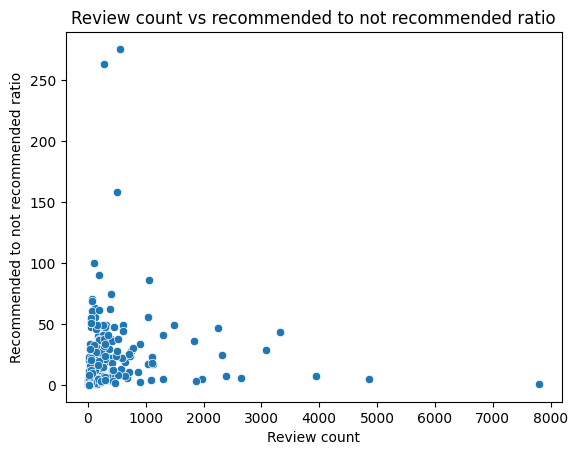

In [36]:
sns.scatterplot(
    x='review_count',
    y='recommended_to_not_recommended_ratio',
    data=most_reviewed_games_pdf
)

plt.xlabel('Review count')
plt.ylabel('Recommended to not recommended ratio')
plt.title('Review count vs recommended to not recommended ratio')
plt.show()

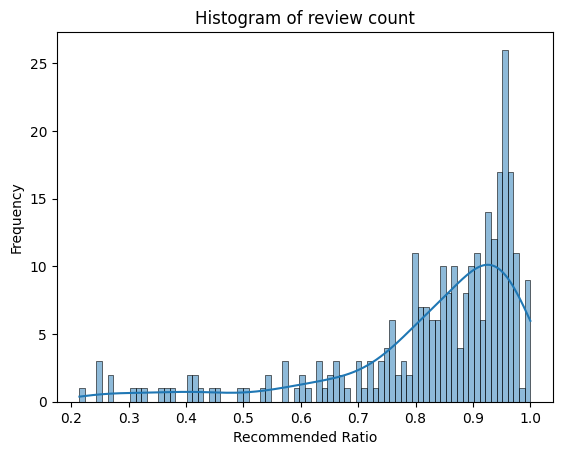

In [41]:
sns.histplot(
    most_reviewed_games_pdf['recommended_ratio'],
    bins=80,
    kde=True
)
plt.xlabel('Recommended Ratio')
plt.ylabel('Frequency')
plt.title('Histogram of review count')
plt.show()

In [ ]:
game_reviews\
    .filter(game_reviews.author_steamid > 100)\
    .groupBy(game_reviews.app_id, game_reviews.author_steamid)\
    .agg(
        F.count('review_id').alias('review_count'),
    )\
    .orderBy(F.desc('review_count'))\
    .show(
        5
    )

+------+-----------------+------------+
|app_id|   author_steamid|review_count|
+------+-----------------+------------+
|262060|76561197989818284|           1|
|524220|76561198314474443|           1|
|524220|76561198008602929|           1|
|872790|76561198132311458|           1|
|613100|76561197981402300|           1|
+------+-----------------+------------+
only showing top 5 rows



In [61]:
game_reviews\
    .filter(F.col("app_id").isNull())\
    .count()

0

# Collaborative filtering

## ALS model

In [67]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer

game_ratings = game_reviews\
    .filter(F.col("author_steamid").isNotNull())\
    .withColumn(
        'rating',
        F.when(game_reviews.recommended == True, 1).otherwise(-1)
    )

user_indexer = StringIndexer(inputCol="author_steamid", outputCol="user_index")
game_ratings = user_indexer.fit(game_ratings).transform(game_ratings)

reviews_train, reviews_test = game_ratings\
    .randomSplit([0.8, 0.2], seed=1234)

als = ALS(
    maxIter=5,
    rank=10,
    regParam=0.01,
    userCol="user_index",
    itemCol="app_id",
    ratingCol="rating",
    coldStartStrategy="drop"
)

In [68]:
model = als.fit(reviews_train)

predictions = model.transform(reviews_test).cache()

24/11/09 17:58:51 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/11/09 17:58:52 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/11/09 17:58:52 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/11/09 17:58:52 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/11/09 17:58:53 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/11/09 17:58:53 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/11/09 17:58:53 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/11/09 17:58:54 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/11/09 17:58:54 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/11/09 17:58:54 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/11/09 17:58:54 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/11/09 17:58:55 WARN DAGScheduler: Broadcasting larg

In [81]:
# Round predictions to -1 or 1
rounded_pred = predictions\
    .withColumn(
        'prediction',
        F.when(F.col('prediction') > 0, 1.).otherwise(-1.)
    )\
    .select('rating', 'prediction')\

rounded_pred.show()

24/11/09 18:13:20 WARN DAGScheduler: Broadcasting large task binary with size 2030.8 KiB
24/11/09 18:13:20 WARN DAGScheduler: Broadcasting large task binary with size 2030.8 KiB
24/11/09 18:13:20 WARN DAGScheduler: Broadcasting large task binary with size 2030.8 KiB


+------+----------+
|rating|prediction|
+------+----------+
|     1|       1.0|
|     1|      -1.0|
|     1|       1.0|
|     1|       1.0|
|     1|      -1.0|
|    -1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|    -1|       1.0|
|     1|      -1.0|
|    -1|      -1.0|
|     1|      -1.0|
|     1|       1.0|
|    -1|      -1.0|
+------+----------+
only showing top 20 rows



In [ ]:
# Calculate RMSE
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)

rmse = evaluator.evaluate(rounded_pred)
print(f"Root-mean-square error = {rmse}")

# Calculate accuracy
correct = rounded_pred\
    .filter(F.col('rating') == F.col('prediction'))\
    .count()

total = rounded_pred.count()

accuracy = correct / total

print(f"Accuracy = {accuracy}")

24/11/09 18:11:15 WARN DAGScheduler: Broadcasting large task binary with size 2042.9 KiB
24/11/09 18:11:17 WARN DAGScheduler: Broadcasting large task binary with size 2044.0 KiB


Root-mean-square error = 1.0532687216470449


24/11/09 18:11:17 WARN DAGScheduler: Broadcasting large task binary with size 2034.4 KiB
24/11/09 18:11:19 WARN DAGScheduler: Broadcasting large task binary with size 2031.4 KiB


Accuracy = 0.72265625


# Content based filtering